Pierre Nikitits

<div class="alert alert-block alert-info">
<b>RL Assignment: Summary</b>

- Model 1: On-policy first-visit Monte Carlo control

- Model 2: Sarsa($\lambda$)

</div>

---

In [15]:
import gymnasium as gym
import text_flappy_bird_gym

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from collections import defaultdict
import wandb

---

<div class="alert alert-block alert-info">
<b>Part 1: Monte Carlo Agent</b>

On-policy first-visit Monte Carlo control

- Model definition
- Training
- Results
    - Reward over episodes plot
    - State value plot
- Hyperparameter search

</div>

Model definition

In [16]:
class EpsilonSoftMC:
    def __init__(self , observation_space , action_space , gamma=0.95 , epsilon=0.4 , decay_rate=0.999 , min_epsilon=0.00001):
        
        self.observation_space = observation_space
        self.num_states = observation_space[0].n * observation_space[1].n
        self.num_actions = action_space.n
        
        self.gamma = gamma # discount factor
        
        # small epsilon for epsilon-soft policy
        self.epsilon = epsilon
        self.decay_rate = decay_rate
        self.min_epsilon = min_epsilon
        
        # init Q for all state action pairs
        self.Q = defaultdict(lambda: np.zeros(self.num_actions))
        
        # init returns list for all state action pairs
        self.returns = defaultdict(list)
        
        # init policy
        self.policy = defaultdict(lambda: 1 / self.num_actions)
    
    def choose_action(self , state):
        # epsilon greedy
        if np.random.rand() > self.epsilon:
            action = np.argmax(self.Q[state])
        else:
            action = np.random.choice(self.num_actions)
        return action
    
    def update(self , episode):
        # find all state action pairs we've visited in this episode
        sa_in_episode = set([(tuple(x[0]) , x[1]) for x in episode])

        for state , action in sa_in_episode:

            sa_pair = (state , action)
            first_occurence_idx = next(i for i , x in enumerate(episode) if x[0] == state and x[1] == action)
            
            G = sum([x[2] * (self.gamma**i) for i , x in enumerate(episode[first_occurence_idx:])]) # sum up all rewards since the first occurrence
            self.returns[sa_pair].append(G)

            self.Q[state][action] = np.average(self.returns[sa_pair]) # calculate average return for this state over all sampled episodes
            
            A_star = np.argmax(self.Q[state]) # find the best action for this state

            # update the policy to be epsilon greedy
            for a in range(self.num_actions):
                if a == A_star:
                    self.policy[state] = [(1 - self.epsilon) + (self.epsilon / self.num_actions)]
                else:
                    self.policy[state] = [self.epsilon / self.num_actions]

    def set_epsilon(self):
        # decay epsilon
        self.epsilon = max(self.min_epsilon , self.epsilon * self.decay_rate)


    def plot_state_values(self):
        # plot the max q value for each state
        V = np.zeros((self.observation_space[1].n , self.observation_space[0].n))
        
        
        for state in range(self.num_states):
            
            row = state % self.observation_space[1].n
            col = state // self.observation_space[1].n

            V[row , col] = np.max(self.Q[(row , col)])

        fig , ax = plt.subplots(figsize=(10 , 8))
        cax = ax.matshow(V, cmap=plt.cm.coolwarm)
        fig.colorbar(cax)
        plt.title("State-Value Function $V(s)$")
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()

Train loop

In [17]:
def train(env , agent , episodes):
    rewards = []
    epsilon_values = []

    for ep in range(episodes):
        agent.set_epsilon()
        epsilon_values.append(agent.epsilon)

        episode = []
        state , _ = env.reset()

        done = False
        while not done:

            # choose action according to the policy
            action = agent.choose_action(state)
            # take action and observe R, S'
            next_state , reward , done , _ , _ = env.step(action)

            episode.append((state , action , reward))
            state = next_state

        
        agent.update(episode)

        rewards.append(sum(x[2] for x in episode))
    
    return agent , rewards , epsilon_values

Average over multiple runs

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [02:13<00:00,  6.65s/it]


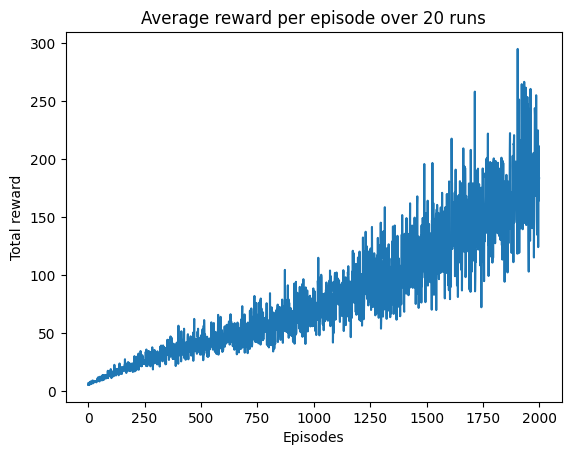

In [18]:
number_of_runs = 20
reward_arrays = []

for i in tqdm(range(number_of_runs)):
    env = gym.make('TextFlappyBird-v0' , height=15 , width=20 , pipe_gap=4)
    agent = EpsilonSoftMC(env.observation_space , env.action_space)
    trained_agent , rewards , epsilon_values = train(env , agent , 2000)
    reward_arrays.append(rewards)
    env.close()

# calculate the average reward over all runs
average_rewards = np.mean(reward_arrays , axis=0)



plt.plot(average_rewards)
plt.xlabel('Episodes')
plt.ylabel('Total reward')
plt.title(f'Average reward per episode over {number_of_runs} runs')
plt.show()

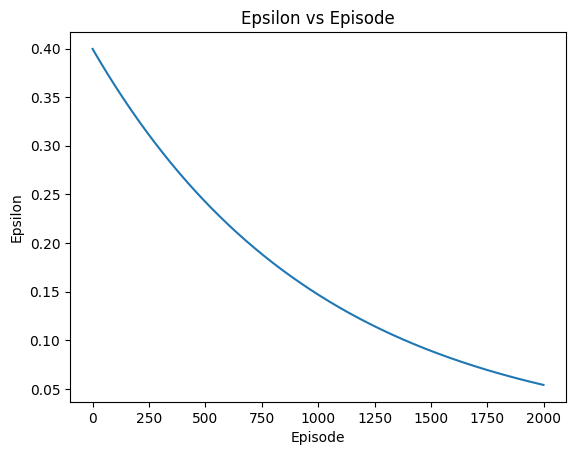

In [19]:
# check the epsilon decay
plt.plot(epsilon_values)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon vs Episode")
plt.show()

State value function

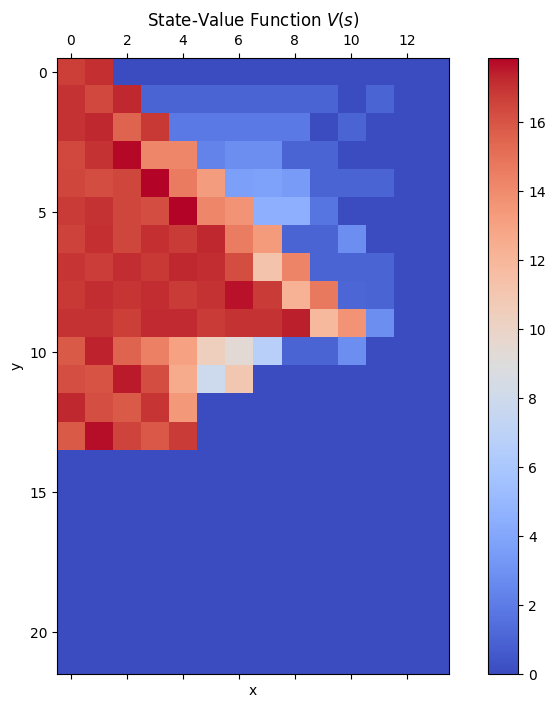

In [20]:
trained_agent.plot_state_values()

Hyper parameter search

In [7]:
# setup setting for wandb bayesian optimisation
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'reward',
        'goal': 'maximize'
    },
    'parameters': {
        'gamma': {
            'values': [0.1 , 0.5 , 0.9]
        },
        'epsilon': {
            'values': [0.1 , 0.5 , 0.9]
        },
        'decay_rate': {
            'values': [0.1 , 0.5 , 0.9]
        },
        'min_epsilon': {
            'values': [0.00001 , 0.0001 , 0.001]
        }
    }
}

sweep_id = wandb.sweep(sweep_config , project="flappy-bird-mc")

def train_agent():
    with wandb.init() as run:
        config = wandb.config
        env = gym.make('TextFlappyBird-v0' , height=15 , width=20 , pipe_gap=4)
        agent = EpsilonSoftMC(env.observation_space,
                              env.action_space,
                              gamma       = config.gamma,
                              epsilon     = config.epsilon,
                              decay_rate  = config.decay_rate,
                              min_epsilon = config.min_epsilon)
        
        _ , rewards , _ = train(env , agent , 1000)
        env.close()
        wandb.log({'reward': np.mean(rewards)})
        return np.mean(rewards)
    
# set to true to run the sweep (takes a long time)
if True:
    wandb.agent(sweep_id , train_agent , count=20)


    # get the results of the sweep
    sweep_results = wandb.Api().sweep(sweep_id)
    best_run = sweep_results.best_run()
    best_config = best_run.config

    print(f"Best config: {best_config}")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: d5pj203r
Sweep URL: https://wandb.ai/pnikitits_1/flappy-bird-mc/sweeps/d5pj203r


wandb: Agent Starting Run: r2tnar7n with config:
wandb: 	decay_rate: 0.5
wandb: 	epsilon: 0.5
wandb: 	gamma: 0.1
wandb: 	min_epsilon: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pnikitits (pnikitits_1). Use `wandb login --relogin` to force relogin


reward,▁
reward,4.545


wandb: Agent Starting Run: 2dzaxj7a with config:
wandb: 	decay_rate: 0.5
wandb: 	epsilon: 0.5
wandb: 	gamma: 0.1
wandb: 	min_epsilon: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


reward,▁
reward,4.108


wandb: Agent Starting Run: x9ofut1q with config:
wandb: 	decay_rate: 0.9
wandb: 	epsilon: 0.5
wandb: 	gamma: 0.9
wandb: 	min_epsilon: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


reward,▁
reward,6.127


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qd1esxy9 with config:
wandb: 	decay_rate: 0.9
wandb: 	epsilon: 0.9
wandb: 	gamma: 0.9
wandb: 	min_epsilon: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


reward,▁
reward,7.115


wandb: Agent Starting Run: y2o6svto with config:
wandb: 	decay_rate: 0.5
wandb: 	epsilon: 0.9
wandb: 	gamma: 0.9
wandb: 	min_epsilon: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


reward,▁
reward,4.387


wandb: Agent Starting Run: kjctnffu with config:
wandb: 	decay_rate: 0.1
wandb: 	epsilon: 0.1
wandb: 	gamma: 0.5
wandb: 	min_epsilon: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


reward,▁
reward,4.306


wandb: Agent Starting Run: j958io8o with config:
wandb: 	decay_rate: 0.5
wandb: 	epsilon: 0.1
wandb: 	gamma: 0.5
wandb: 	min_epsilon: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


reward,▁
reward,4.107


wandb: Agent Starting Run: 10ylg6ub with config:
wandb: 	decay_rate: 0.1
wandb: 	epsilon: 0.1
wandb: 	gamma: 0.5
wandb: 	min_epsilon: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


reward,▁
reward,4.012


wandb: Agent Starting Run: vxumd3r1 with config:
wandb: 	decay_rate: 0.1
wandb: 	epsilon: 0.1
wandb: 	gamma: 0.1
wandb: 	min_epsilon: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


reward,▁
reward,4.003


wandb: Agent Starting Run: gvyj8goy with config:
wandb: 	decay_rate: 0.9
wandb: 	epsilon: 0.9
wandb: 	gamma: 0.9
wandb: 	min_epsilon: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


reward,▁
reward,13.067


wandb: Agent Starting Run: 8qo8pvl6 with config:
wandb: 	decay_rate: 0.9
wandb: 	epsilon: 0.9
wandb: 	gamma: 0.9
wandb: 	min_epsilon: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


reward,▁
reward,9.21


wandb: Agent Starting Run: 4q1ge3wm with config:
wandb: 	decay_rate: 0.1
wandb: 	epsilon: 0.9
wandb: 	gamma: 0.1
wandb: 	min_epsilon: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


reward,▁
reward,4.0


wandb: Agent Starting Run: x08b4dtk with config:
wandb: 	decay_rate: 0.1
wandb: 	epsilon: 0.1
wandb: 	gamma: 0.1
wandb: 	min_epsilon: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


reward,▁
reward,4.0


wandb: Agent Starting Run: qtc2vkga with config:
wandb: 	decay_rate: 0.1
wandb: 	epsilon: 0.1
wandb: 	gamma: 0.9
wandb: 	min_epsilon: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


reward,▁
reward,4.0


wandb: Agent Starting Run: wmwavqts with config:
wandb: 	decay_rate: 0.9
wandb: 	epsilon: 0.1
wandb: 	gamma: 0.1
wandb: 	min_epsilon: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


reward,▁
reward,4.091


wandb: Agent Starting Run: 8ezsjp4a with config:
wandb: 	decay_rate: 0.9
wandb: 	epsilon: 0.9
wandb: 	gamma: 0.9
wandb: 	min_epsilon: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


reward,▁
reward,14.01


wandb: Agent Starting Run: nvkgq6aj with config:
wandb: 	decay_rate: 0.9
wandb: 	epsilon: 0.9
wandb: 	gamma: 0.9
wandb: 	min_epsilon: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


reward,▁
reward,8.706


wandb: Agent Starting Run: k8mqpclg with config:
wandb: 	decay_rate: 0.9
wandb: 	epsilon: 0.9
wandb: 	gamma: 0.9
wandb: 	min_epsilon: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


reward,▁
reward,11.993


wandb: Agent Starting Run: i9aj7b5o with config:
wandb: 	decay_rate: 0.9
wandb: 	epsilon: 0.9
wandb: 	gamma: 0.9
wandb: 	min_epsilon: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


reward,▁
reward,8.402


wandb: Agent Starting Run: 9571nv4u with config:
wandb: 	decay_rate: 0.9
wandb: 	epsilon: 0.9
wandb: 	gamma: 0.9
wandb: 	min_epsilon: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


reward,▁
reward,5.253


wandb: Sorting runs by -summary_metrics.reward


Best config: {'gamma': 0.9, 'epsilon': 0.9, 'decay_rate': 0.9, 'min_epsilon': 1e-05}


<div class="alert alert-block alert-info">
<b>Part 2: Sarsa Agent</b>

Sarsa($\lambda$) with binary features and linear function approximation

</div>

Model definition

In [8]:
class SarsaLambdaAgent:
    def __init__(self , action_space , agent_settings):
        self.action_space = action_space

        self.alpha = agent_settings["alpha"]
        self.gamma = agent_settings["gamma"]
        self.lam = agent_settings["lam"]
        self.epsilon = agent_settings["epsilon"]
        self.epsilon_decay = agent_settings["epsilon_decay"]
        self.epsilon_min = agent_settings["epsilon_min"]

        self.Q = {} # q values
        self.E = {} # eligibility traces

    def choose_action(self , state):
        # epsilon greedy
        if np.random.uniform(0 , 1) < self.epsilon:
            return self.action_space.sample()
        else:
            q_values = [self.get_Q(state , a) for a in range(self.action_space.n)]
            return np.argmax(q_values)

    def get_Q(self , state , action):
        # return 0 if we haven't seen this state-action pair before
        return self.Q.get((state , action) , 0.0)

    def update(self , state , action , reward , next_state , next_action , done):
        sa_pair = (state , action)

        q_current = self.get_Q(state , action)
        q_next = self.get_Q(next_state , next_action) if not done else 0

        delta = reward + self.gamma * q_next - q_current

        self.E[sa_pair] = self.E.get(sa_pair , 0.0) + 1

        for sa in self.E:
            self.Q[sa] = self.Q.get(sa , 0.0) + self.alpha * delta * self.E[sa]
            self.E[sa] *= self.gamma * self.lam

        self.epsilon = max(self.epsilon * self.epsilon_decay , self.epsilon_min)




    def plot_state_values(self):
        grid_width = 15
        grid_height = 20
        V = np.zeros((grid_height , grid_width))

        for state in self.Q:
            x , y = state[0]
            action_values = [self.get_Q((x , y) , a) for a in range(self.action_space.n)]
            V[x , y] = np.max(action_values)

        fig , ax = plt.subplots(figsize=(10 , 8))
        cax = ax.matshow(V, cmap=plt.cm.coolwarm)
        fig.colorbar(cax)
        plt.title("State-Value Function $V(s)$")
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()

Train loop

In [9]:
def train_sarsa(env , agent , episodes):

    rewards = []
    log_epsilons = []

    for _ in tqdm(range(episodes)):
        state = env.reset()[0]
        action = agent.choose_action(state)
        done = False

        total_reward = 0

        while not done:
            next_state , reward , done , _ , _ = env.step(action)
            next_action = agent.choose_action(next_state)
            agent.update(state , action , reward , next_state , next_action , done)
            state , action = next_state , next_action
            total_reward += reward

        rewards.append(total_reward)
        log_epsilons.append(agent.epsilon)

    env.close()
    return agent , rewards , log_epsilons

In [10]:
env = gym.make('TextFlappyBird-v0' , height=15 , width=20 , pipe_gap=4)

SarsaSettings = {
    "alpha": 0.12,
    "gamma": 0.9999,
    "lam": 0.9,
    "epsilon": 0.1,
    "epsilon_decay": 0.99999,
    "epsilon_min": 0.0001
}

agent = SarsaLambdaAgent(env.action_space , SarsaSettings)

episodes = 4000
trained_agent , rewards , log_epsilons = train_sarsa(env , agent , episodes)

100%|██████████| 4000/4000 [00:30<00:00, 130.90it/s] 


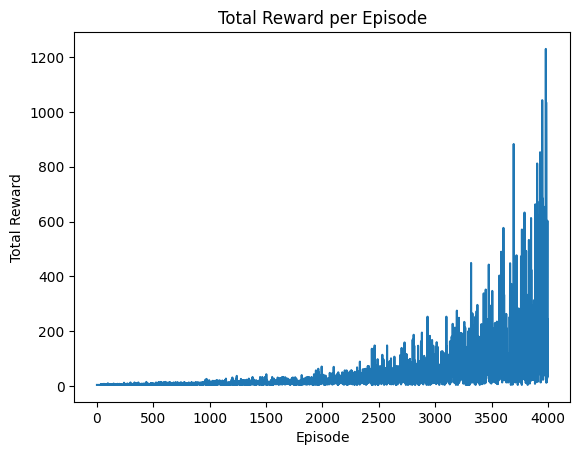

In [11]:
# plot the rewards
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode")
plt.show()

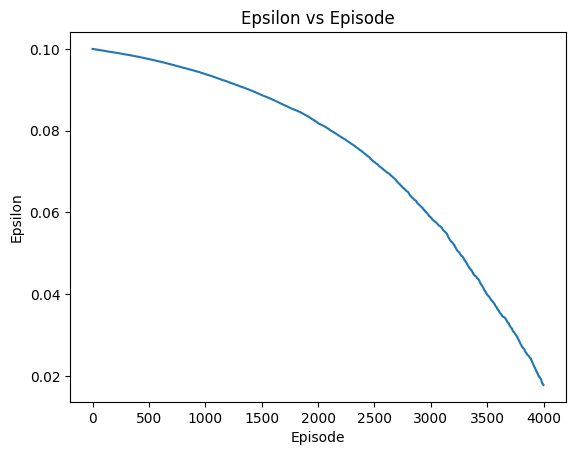

In [12]:
# plot the epsilon decay
plt.plot(log_epsilons)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon vs Episode")
plt.show()

State value function

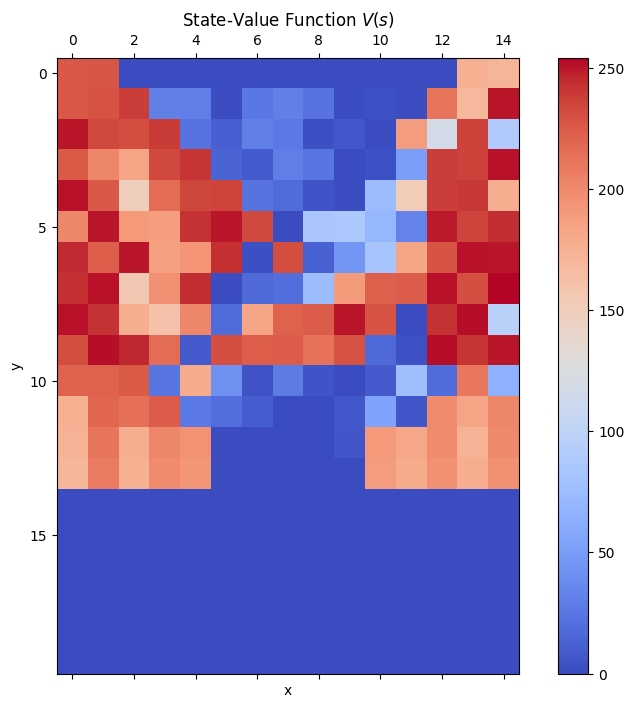

In [13]:
trained_agent.plot_state_values()

Hyper parameter search

In [14]:
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'reward',
        'goal': 'maximize'
    },
    'parameters': {
        'alpha': {
            'values': [0.1 , 0.5 , 0.9]
        },
        'gamma': {
            'values': [0.1 , 0.5 , 0.9]
        },
        'lam': {
            'values': [0.1 , 0.5 , 0.9]
        },
        'epsilon': {
            'values': [0.1 , 0.5 , 0.9]
        },
        'epsilon_decay': {
            'values': [0.1 , 0.5 , 0.9]
        },
        'epsilon_min': {
            'values': [0.00001 , 0.0001 , 0.001]
        }
    }
}

sweep_id = wandb.sweep(sweep_config , project="flappy-bird-sarsa")

def train_agent():
    with wandb.init() as run:
        config = wandb.config
        env = gym.make('TextFlappyBird-v0' , height=15 , width=20 , pipe_gap=4)
        agent = SarsaLambdaAgent(env.action_space , config)
        _ , rewards , _ = train_sarsa(env , agent , 1000)
        env.close()
        wandb.log({'reward': np.mean(rewards)})
        return np.mean(rewards)
    
# set to true to run the sweep (takes a long time)
if True:
    wandb.agent(sweep_id , train_agent , count=20)

    sweep_results = wandb.Api().sweep(sweep_id)
    best_run = sweep_results.best_run()
    best_config = best_run.config

    print(f"Best config: {best_config}")

Create sweep with ID: 4zn6ispr
Sweep URL: https://wandb.ai/pnikitits_1/flappy-bird-sarsa/sweeps/4zn6ispr


wandb: Agent Starting Run: f3df4hgl with config:
wandb: 	alpha: 0.1
wandb: 	epsilon: 0.9
wandb: 	epsilon_decay: 0.5
wandb: 	epsilon_min: 0.0001
wandb: 	gamma: 0.1
wandb: 	lam: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 1000/1000 [00:00<00:00, 5856.79it/s]


reward,▁
reward,4.212


wandb: Agent Starting Run: w3keuf1v with config:
wandb: 	alpha: 0.9
wandb: 	epsilon: 0.9
wandb: 	epsilon_decay: 0.1
wandb: 	epsilon_min: 1e-05
wandb: 	gamma: 0.9
wandb: 	lam: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 1000/1000 [00:00<00:00, 5907.86it/s]


reward,▁
reward,4.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jy0vsst3 with config:
wandb: 	alpha: 0.9
wandb: 	epsilon: 0.1
wandb: 	epsilon_decay: 0.1
wandb: 	epsilon_min: 0.001
wandb: 	gamma: 0.5
wandb: 	lam: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 1000/1000 [00:00<00:00, 5858.71it/s]


reward,▁
reward,4.088


wandb: Agent Starting Run: rxau5y08 with config:
wandb: 	alpha: 0.5
wandb: 	epsilon: 0.9
wandb: 	epsilon_decay: 0.1
wandb: 	epsilon_min: 0.0001
wandb: 	gamma: 0.1
wandb: 	lam: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 1000/1000 [00:00<00:00, 6412.60it/s]


reward,▁
reward,4.0


wandb: Agent Starting Run: b4sm9lye with config:
wandb: 	alpha: 0.1
wandb: 	epsilon: 0.1
wandb: 	epsilon_decay: 0.9
wandb: 	epsilon_min: 1e-05
wandb: 	gamma: 0.1
wandb: 	lam: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 1000/1000 [00:00<00:00, 6201.86it/s]


reward,▁
reward,4.0


wandb: Agent Starting Run: mloqgj4x with config:
wandb: 	alpha: 0.9
wandb: 	epsilon: 0.5
wandb: 	epsilon_decay: 0.1
wandb: 	epsilon_min: 1e-05
wandb: 	gamma: 0.9
wandb: 	lam: 0.9
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 1000/1000 [00:00<00:00, 4594.37it/s]


reward,▁
reward,5.425


wandb: Agent Starting Run: gqwraclx with config:
wandb: 	alpha: 0.9
wandb: 	epsilon: 0.5
wandb: 	epsilon_decay: 0.1
wandb: 	epsilon_min: 1e-05
wandb: 	gamma: 0.9
wandb: 	lam: 0.9
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 1000/1000 [00:00<00:00, 5747.76it/s]


reward,▁
reward,4.515


wandb: Agent Starting Run: jt1bd2t5 with config:
wandb: 	alpha: 0.9
wandb: 	epsilon: 0.9
wandb: 	epsilon_decay: 0.5
wandb: 	epsilon_min: 1e-05
wandb: 	gamma: 0.9
wandb: 	lam: 0.9
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 1000/1000 [00:00<00:00, 4723.75it/s]


reward,▁
reward,5.306


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7xbf2kun with config:
wandb: 	alpha: 0.5
wandb: 	epsilon: 0.9
wandb: 	epsilon_decay: 0.9
wandb: 	epsilon_min: 0.0001
wandb: 	gamma: 0.9
wandb: 	lam: 0.9
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 1000/1000 [00:00<00:00, 5231.33it/s]


reward,▁
reward,4.78


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pv5qnakk with config:
wandb: 	alpha: 0.9
wandb: 	epsilon: 0.9
wandb: 	epsilon_decay: 0.9
wandb: 	epsilon_min: 1e-05
wandb: 	gamma: 0.9
wandb: 	lam: 0.9
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 1000/1000 [00:00<00:00, 4805.62it/s]


reward,▁
reward,4.565


wandb: Agent Starting Run: wgj6blvq with config:
wandb: 	alpha: 0.9
wandb: 	epsilon: 0.9
wandb: 	epsilon_decay: 0.9
wandb: 	epsilon_min: 1e-05
wandb: 	gamma: 0.9
wandb: 	lam: 0.9
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 1000/1000 [00:00<00:00, 4435.55it/s]


reward,▁
reward,5.134


wandb: Agent Starting Run: 09cdsctq with config:
wandb: 	alpha: 0.9
wandb: 	epsilon: 0.9
wandb: 	epsilon_decay: 0.5
wandb: 	epsilon_min: 1e-05
wandb: 	gamma: 0.9
wandb: 	lam: 0.9
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 1000/1000 [00:00<00:00, 3610.98it/s]


reward,▁
reward,6.551


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ud4zvxaf with config:
wandb: 	alpha: 0.9
wandb: 	epsilon: 0.9
wandb: 	epsilon_decay: 0.9
wandb: 	epsilon_min: 1e-05
wandb: 	gamma: 0.9
wandb: 	lam: 0.9
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 1000/1000 [00:00<00:00, 3827.86it/s]


reward,▁
reward,6.375


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: op78pfzk with config:
wandb: 	alpha: 0.9
wandb: 	epsilon: 0.9
wandb: 	epsilon_decay: 0.5
wandb: 	epsilon_min: 1e-05
wandb: 	gamma: 0.5
wandb: 	lam: 0.9
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 1000/1000 [00:00<00:00, 5991.39it/s]


reward,▁
reward,4.0


wandb: Agent Starting Run: igwmjwdy with config:
wandb: 	alpha: 0.5
wandb: 	epsilon: 0.1
wandb: 	epsilon_decay: 0.9
wandb: 	epsilon_min: 1e-05
wandb: 	gamma: 0.5
wandb: 	lam: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 1000/1000 [00:00<00:00, 3605.39it/s]


reward,▁
reward,4.0


wandb: Agent Starting Run: d4k78uy4 with config:
wandb: 	alpha: 0.9
wandb: 	epsilon: 0.5
wandb: 	epsilon_decay: 0.5
wandb: 	epsilon_min: 0.0001
wandb: 	gamma: 0.5
wandb: 	lam: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 1000/1000 [00:00<00:00, 5551.08it/s]


reward,▁
reward,4.21


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7fspfdb9 with config:
wandb: 	alpha: 0.9
wandb: 	epsilon: 0.9
wandb: 	epsilon_decay: 0.1
wandb: 	epsilon_min: 1e-05
wandb: 	gamma: 0.9
wandb: 	lam: 0.9
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 1000/1000 [00:00<00:00, 5015.77it/s]


reward,▁
reward,4.35


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: oobrll1n with config:
wandb: 	alpha: 0.9
wandb: 	epsilon: 0.5
wandb: 	epsilon_decay: 0.5
wandb: 	epsilon_min: 0.0001
wandb: 	gamma: 0.9
wandb: 	lam: 0.9
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 1000/1000 [00:00<00:00, 5491.64it/s]


reward,▁
reward,4.402


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5gpkpni9 with config:
wandb: 	alpha: 0.1
wandb: 	epsilon: 0.5
wandb: 	epsilon_decay: 0.1
wandb: 	epsilon_min: 0.0001
wandb: 	gamma: 0.9
wandb: 	lam: 0.9
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 1000/1000 [00:00<00:00, 6329.63it/s]


reward,▁
reward,4.0


wandb: Agent Starting Run: it18efdz with config:
wandb: 	alpha: 0.1
wandb: 	epsilon: 0.1
wandb: 	epsilon_decay: 0.5
wandb: 	epsilon_min: 0.0001
wandb: 	gamma: 0.5
wandb: 	lam: 0.9
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 1000/1000 [00:00<00:00, 7319.20it/s]


reward,▁
reward,4.0


wandb: Sorting runs by -summary_metrics.reward


Best config: {'lam': 0.9, 'alpha': 0.9, 'gamma': 0.9, 'epsilon': 0.9, 'epsilon_min': 1e-05, 'epsilon_decay': 0.5}
